In [1]:
import sqlite3
import pandas as pd
import yaml
import seaborn as sb
from sklearn.preprocessing import StandardScaler, OneHotEncoder

#### connect sqlite database

In [2]:
# If fail, please run preprocessing notebook first 
with open("config.yml", "r") as f:
    config = yaml.safe_load(f)
con = sqlite3.connect(f"{config['SQLITE_DATABASE_DIR']}/ICU.db")

In [3]:
data = pd.read_sql_query('select * from ICU', con)
data     

,ID,Survive,Age,AgeGroup,Sex,Infection,SysBP,Pulse,Emergency
0,4,0,87,3,1,1,80,96,1
1,8,1,27,1,1,1,142,88,1
2,12,1,59,2,0,0,112,80,1
3,14,1,77,3,0,0,100,70,0
4,27,0,76,3,1,1,128,90,1
...,...,...,...,...,...,...,...,...,...
195,921,0,50,2,1,0,256,64,1
196,923,1,20,1,0,0,104,83,1
197,924,1,73,3,1,0,162,100,1
198,925,1,59,2,0,0,100,88,1


### preprocessing

In [4]:
feature_colname = data.columns[2:].tolist()
target_colname = "Survive"

numerical_cols = ["Age", "SysBP", "Pulse"]
categorical_cols = ["Sex", "Infection", "Emergency", "AgeGroup"]
multiclass_cols = ['AgeGroup']
binary_cols = ["Sex", "Infection", "Emergency"]

In [5]:
# no NAs to handle
data.isna().sum()

ID           0
Survive      0
Age          0
AgeGroup     0
Sex          0
Infection    0
SysBP        0
Pulse        0
Emergency    0
dtype: int64

In [7]:
def normalize(df, cols):
    ss = StandardScaler()
    ss.fit(df[cols])
    output = pd.DataFrame(ss.transform(df[cols]), columns = cols)
    return output
def set_categoric(df, cols):
    for c in cols:
        df[c] = df[c].astype(object)
    return df[cols]
def set_float(df):
    for c in df.columns:
        df[c] = df[c].astype(float)
    return df
def onehot_encode(df, cols):
    output = pd.DataFrame()
    ohe = OneHotEncoder(drop = "first", sparse = False)
    for c in cols:
        ohe.fit(df[[c]])
        oh_data = ohe.transform(data[["AgeGroup"]])
        new_col_names = [f"{c}_onehot_{i}" for i in range(oh_data.shape[1])]
        output = pd.concat([output, pd.DataFrame(oh_data, columns = new_col_names)], axis = 1)
    return output

In [8]:
normalized_df = normalize(data, cols = numerical_cols)
categoric_df = set_categoric(data, cols = categorical_cols)
preprocessed_data = pd.concat([normalized_df,categoric_df, data[[target_colname]]], axis = 1)

In [9]:
preprocessed_data

,Age,SysBP,Pulse,Sex,Infection,Emergency,AgeGroup,Survive
0,1.472422,-1.590527,-0.109295,1,1,1,3,0
1,-1.526910,0.295714,-0.408221,1,1,1,1,1
2,0.072734,-0.616983,-0.707147,0,0,1,2,1
3,0.972534,-0.982062,-1.080805,0,0,0,3,1
4,0.922545,-0.130211,-0.333489,1,1,1,3,0
...,...,...,...,...,...,...,...,...
195,-0.377166,3.763963,-1.305000,1,0,1,2,0
196,-1.876833,-0.860369,-0.595050,0,0,1,1,1
197,0.772578,0.904179,0.040168,1,0,1,3,1
198,0.072734,-0.982062,-0.408221,0,0,1,2,1


In [10]:
# both decTrees and RanFor models can handle categoric data so we pass categoric data without further processing
preprocessed_data.dtypes

Age          float64
SysBP        float64
Pulse        float64
Sex           object
Infection     object
Emergency     object
AgeGroup      object
Survive        int64
dtype: object

# Random Grid Search CV

In [29]:
results = {
    "model":[],
    "score":[],
    "best_param":[]
}

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats
import numpy as np
from joblib import dump, load
import pickle
from sklearn.metrics import fbeta_score, make_scorer

In [20]:
X = preprocessed_data[feature_colname]
y = preprocessed_data[target_colname].astype(int)

#### metric: fbeta_score
- the motivation is to prioritize people who are likely not going to survive and give them more attention
- we can achieve that with f1_score beta>1 which leans more towards recall
- at the same time we do not want to neglect precision, otherwise we'll be predicting everybody as likely not going to survive
- thus, fbeta score is a good choice

In [14]:
ftwo_scorer = make_scorer(fbeta_score, beta=1.5)

### random forest

In [30]:
param_grid = {
    "n_estimators" : range(30,101), 
    "max_depth" : range(2,10), 
    "max_features" : range(2, len(X.columns)), 
    "class_weight" : [None, "balanced", "balanced_subsample"],
    "ccp_alpha": np.arange(0,1,0.05)
}

In [31]:
model = RandomForestClassifier(
    bootstrap = True, 
    random_state = 0, 
)

In [32]:
gs_cv = RandomizedSearchCV(model, 
                           param_grid, 
                           n_iter = 200,
                           scoring = ftwo_scorer,
                           # scoring = ["accuracy", "recall", "precision", "roc_auc"],
                           n_jobs = -1,
                           random_state = 0,
                           cv = 5) 
gs_cv_output = gs_cv.fit(X, y)

##### save model and results 

In [33]:
dump(gs_cv, f"{config['MODEL_DIR']}/rf.joblib")

['./models/rf.joblib']

In [34]:
results['model'].append("Random Forest")
results['score'].append(gs_cv_output.best_score_)
results['best_param'].append(gs_cv_output.best_params_)

### Decision Trees

In [35]:
param_grid = {
    "splitter" : ["best", "random"], 
    "max_depth" : range(2,10), 
    "max_features" : range(2, len(X.columns)), 
    "class_weight" : [None, "balanced"],
    "ccp_alpha": np.arange(0,1,0.05)
}

In [36]:
model = DecisionTreeClassifier(
    random_state = 0, 
)

In [37]:
gs_cv = RandomizedSearchCV(model, 
                           param_grid, 
                           n_iter = 200,
                           scoring = ftwo_scorer,
                           # scoring = ["accuracy", "recall", "precision", "roc_auc"],
                           n_jobs = -1,
                           random_state = 0,
                           refit = "recall",
                           cv = 5) 
gs_cv_output = gs_cv.fit(X, y)

##### save model and results 

In [40]:
dump(gs_cv, f"{config['MODEL_DIR']}/dt.joblib")

['./models/dt.joblib']

In [81]:
results['model'].append("Decision Tree")
results['score'].append(gs_cv_output.best_score_)
results['best_param'].append(gs_cv_output.best_params_)

In [41]:
with open(f"{config['RESULTS_DIR']}/best_results.pkl", "wb") as f:
    pickle.dump(results,f)

## One Hot Encoding
- since logistic regression is a linear model requiring numeric inputs, we one hot encode the categorical features and convert them to numeric

In [42]:
normalized_df = normalize(data, cols = numerical_cols)
onehot_df = onehot_encode(data, cols = multiclass_cols)
preprocessed_data = pd.concat([normalized_df, onehot_df, data[binary_cols+[target_colname]]], axis = 1)
preprocessed_data = set_float(preprocessed_data)

In [43]:
preprocessed_data.head()

,Age,SysBP,Pulse,AgeGroup_onehot_0,AgeGroup_onehot_1,Sex,Infection,Emergency,Survive
0,1.472422,-1.590527,-0.109295,0.0,1.0,1.0,1.0,1.0,0.0
1,-1.526910,0.295714,-0.408221,0.0,0.0,1.0,1.0,1.0,1.0
2,0.072734,-0.616983,-0.707147,1.0,0.0,0.0,0.0,1.0,1.0
3,0.972534,-0.982062,-1.080805,0.0,1.0,0.0,0.0,0.0,1.0
4,0.922545,-0.130211,-0.333489,0.0,1.0,1.0,1.0,1.0,0.0


In [44]:
preprocessed_data.dtypes

Age                  float64
SysBP                float64
Pulse                float64
AgeGroup_onehot_0    float64
AgeGroup_onehot_1    float64
Sex                  float64
Infection            float64
Emergency            float64
Survive              float64
dtype: object

In [45]:
X = preprocessed_data[[c for c in preprocessed_data.columns if c!=target_colname]]
y = preprocessed_data[target_colname].astype(int)

### Logistic Regression

In [46]:
param_grid = {
    "penalty" : ["l1", "l2"], 
    "C" : np.arange(0,2.1,0.2), 
    "class_weight" : [None, "balanced"],
    "max_iter": range(30,150)
}  

In [47]:
model = LogisticRegression(
    random_state = 0, 
    solver = "liblinear"
)

In [48]:
gs_cv = RandomizedSearchCV(model, 
                           param_grid, 
                           n_iter = 200,
                           scoring = ftwo_scorer,
                           # scoring = ["accuracy", "recall", "precision", "roc_auc"],
                           n_jobs = -1,
                           random_state = 0,
                           cv = 5) 
gs_cv_output = gs_cv.fit(X, y)

C:\Users\tanch\anaconda3\envs\dp\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
95 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
95 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\tanch\anaconda3\envs\dp\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\tanch\anaconda3\envs\dp\lib\site-packages\sklearn\linear_model\_logistic.py", line 1158, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\Users\tanch\anaconda3\envs\dp\lib\site-packages\sklearn\svm\_base.py", line 1205, in _fit_liblinear
    

##### save model and results 

In [49]:
dump(gs_cv, f"{config['MODEL_DIR']}/lr.joblib")

['./models/lr.joblib']

In [50]:
results['model'].append("Logistic Regression")
results['score'].append(gs_cv_output.best_score_)
results['best_param'].append(gs_cv_output.best_params_)

# Performance Comparison
- usually it'll be good to plot, but it's not relevant here since the scores are too close
- however, logistic regression does perform the best. The data isn't very big, so a small model like logistic regression is sufficient

In [74]:
results

{'model': ['Random Forest', 'Decision Tree', 'Logistic Regression'],
 'best_param': [{'n_estimators': 74,
   'max_features': 5,
   'max_depth': 4,
   'class_weight': None,
   'ccp_alpha': 0.25},
  {'splitter': 'best',
   'max_features': 5,
   'max_depth': 7,
   'class_weight': None,
   'ccp_alpha': 0.15000000000000002},
  {'penalty': 'l1', 'max_iter': 67, 'class_weight': None, 'C': 0.4}],
 'score': [0.9285714285714286, 0.9285714285714286, 0.9302445302445304]}

# Inspect Feature Importances
- may give us an idea of indicators of survivability
- it appears that only Age, SysBP and Emergency are predictive of survival at ICU

In [53]:
from sklearn.inspection import permutation_importance

In [64]:
importances = permutation_importance(gs_cv, X, y , scoring = ftwo_scorer)

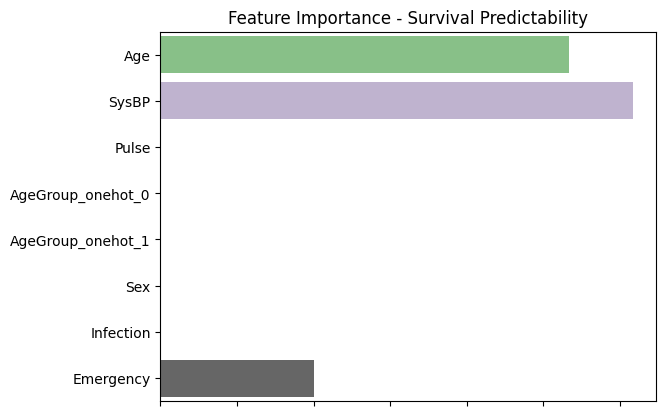

In [69]:
p = sb.barplot(x = importances['importances_mean'], y = X.columns, palette = "Accent")
_ = p.set(title = "Feature Importance - Survival Predictability", xticklabels = [])